# AMEX Default Prediction

## Set up

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pyarrow
from sklearn import preprocessing

## Preprocessing - Supervised

In [2]:
from sklearn.model_selection import train_test_split


In [3]:
# global parameters
SAMPLE = True

In [4]:
# load parquet data
data = pd.read_parquet('dataset/train.parquet')


In [5]:
raw_labels = pd.read_csv('dataset/train_labels.csv')

In [6]:
# use a smaller subset for fast pipeline during testing
if SAMPLE:
    sample = raw_labels['customer_ID'][:10000]
    data = data[data['customer_ID'].isin(sample)]

In [7]:
def preprocessing_pipeline(data, training = False):

    # replace -1's with NA's (to make it simpler to replace nas)
    data.replace(-1, np.nan)

    fill_values = {}
    pbar = tqdm(range(2,len(data.columns)))

    # get means for missing values
    for i in pbar:
        # add to dictionary of means
        fill_values[data.columns[i]] =0 # np.mean(data[data.columns[i]])

    # fill missing values
    data.fillna(value = fill_values, inplace= True)


    # normalize with mean and std scaling


    # aggregate across customer_ids
    data_agg = data.drop('S_2', axis = 1).groupby('customer_ID', as_index = False).sum()

    # normalize again and split into X and y
    X = preprocessing.scale(data_agg.iloc[:,1:])
    if training:
        y = data_agg[['customer_ID']].merge(raw_labels)['target']
        return X,y
    else:
        return X, data_agg['customer_ID']


In [8]:
# train test split
if SAMPLE:
    # preprocess dataset
    X, y = preprocessing_pipeline(data, training= True)

    # split into training and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
else:
    # preprocess train dataset
    X_train, y_train = preprocessing_pipeline(data, training= True)

    # get test dataset
    test_data = pd.read_parquet('dataset/test.parquet')
    X_test, cust_ids = preprocessing_pipeline(test_data, training= False)

    del test_data
    
del data




100%|██████████| 188/188 [00:00<00:00, 3117.39it/s]


## Supervised method

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve

### Evaluation Methods
We want to recreate the evaluation metric from the competition: https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation
For this, first we introduce two terms:

- Normalized Gini Coefficient (G). Here is was calculated from the AUC score using the formula
$$GINI = (2*AUC)-1 $$
- Default rate at 4% (D). This captures a Sensitivity/Recall statistic by calculating the portion of defaults in the highest-ranked 4% of predictions.
  
Using **G** and **D** our evaluaton metric **M** is found by:
$$M = 0.5 \cdot(G+D) $$

The best-performing models achieve scores of 0.80 in this metric, and we hope to achieve accuracy close to that. There appears to be some inconsistency with regards to the training and test data provided by AMEX, as the test data is not merely a random sample of the training data. Instead the test data covers not only a separate set of customers, but also a different time period, Initial results show the M score close to 93% in the validation set, but around 70% in the competition. Therefore, validation accuracy is not a true reflection of test accuracy in this setting.

In [48]:
# recreates evaluation metric from: 
def evaluate_model(y_true, y_score, traditional = False):
    # produce traditional metric such as Precision, Recall, F-measure and accuracy
    if traditional:
        threshold = 0.5
        pred_labels  = (y_score[:,1] > 0.5)
        true_positive = np.sum(np.logical_and(y_true, pred_labels))
        false_positive = np.sum(np.logical_and(1-y_true, pred_labels))
        false_negative = np.sum(np.logical_and(y_true, 1-pred_labels))
        true_negative = np.sum(np.logical_and(1-y_true, 1-pred_labels))

        print("Traditional Metrics:")
        print(f"    tp: {true_positive}, fp: {false_positive}, tn: {true_negative}, fn: {false_negative}")
        precision = true_positive / (true_positive + false_positive)
        print("     The precision score is ", precision)
        recall = true_positive / (true_positive + false_negative)
        print("     The recall score is ", recall)
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
        print("     The accuracy score is ", accuracy)
        fmeasure = 2/(1/precision + 1/recall)
        print("     F-Measure: ", fmeasure)

    AUC = roc_auc_score(y_true, y_score[:,1])
    print(f"AUC Score: {AUC}")

    # GINI from AUC formula: https://yassineelkhal.medium.com/confusion-matrix-auc-and-roc-curve-and-gini-clearly-explained-221788618eb2
    Gini = (AUC*2)-1
    print(f"GINI Score: {Gini}")

    #get top 4% ratio of positive predictions
    fpr, tpr,_ = roc_curve(y_true, y_score[:,1])
    pred_labels.sort()
    pos_samples = np.sum(y_true)
    neg_samples = len(y_true) - pos_samples
    neg_samples_weighted = 20*neg_samples
    total_samples = pos_samples+neg_samples_weighted
    four_percent = int(0.04*total_samples)
    four_percent_index = np.argmax((fpr * neg_samples_weighted + tpr * pos_samples >= four_percent))

    true_positives_at_four_percent = tpr[four_percent_index]*pos_samples

    D = true_positives_at_four_percent/pos_samples
    print(f"Default rate at 4%: {D}")
    
    M = 0.5*(Gini+D)
    print(f"M: {M}")

    return M


# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_score):
    pred_labels = y_score[:,1]>0.5
    cm = confusion_matrix(y_true, pred_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Compliance", "Default"])
    cm_display.plot()
    plt.show()

# Plot GINI (OR AUC) curve
def plot_GINI(y_true, y_score):

    fpr, tpr,_ = roc_curve(y_true, y_score[:,1])
    pos_samples = np.sum(y_true)
    neg_samples = len(y_true) - pos_samples
    neg_samples_weighted = 20*neg_samples
    total_samples = pos_samples+neg_samples_weighted
    four_percent = int(0.04*total_samples)
    four_percent_index = np.argmax((fpr * neg_samples_weighted + tpr * pos_samples >= four_percent))

    RocCurveDisplay.from_predictions(y_true, y_score[:,1])
    plt.axvline(x = 0.04, color = 'r',linestyle = 'dashed')
    plt.scatter([fpr[four_percent_index]],[ tpr[four_percent_index]], s = 100)
    plt.show()



### Model fitting

In [15]:
max_samples_training = -1
xgb = GradientBoostingClassifier()
xgb.fit(X_train[:max_samples_training], y_train[:max_samples_training])
print("finished training")


finished training


In [16]:
pred = xgb.predict_proba(X_test)
print("finished evaluating")

finished evaluating


Traditional Metrics:
    tp: 392, fp: 101, tn: 1381, fn: 126
     The precision score is  0.795131845841785
     The recall score is  0.7567567567567568
     The accuracy score is  0.8865
     F-Measure:  0.7754698318496539
AUC Score: 0.9458234984550775
GINI Score: 0.891646996910155
Default rate at 4%: 0.5637065637065637
M: 0.7276767803083594


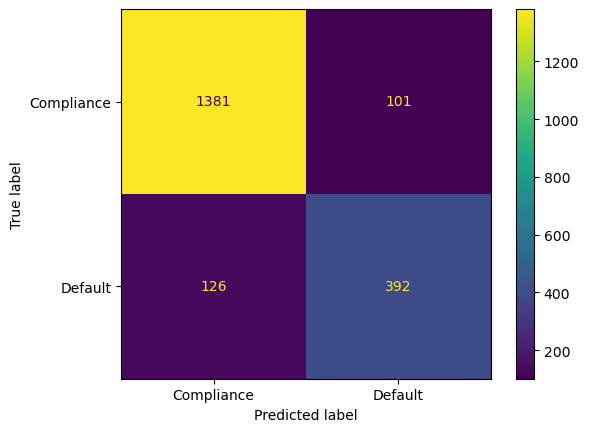

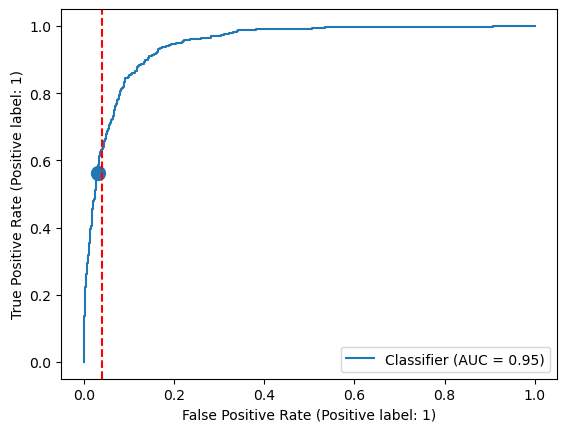

In [49]:
if SAMPLE:
    evaluate_model(y_test, pred, traditional = True)
    plot_confusion_matrix(y_test,pred)
    plot_GINI(y_test,pred)

else:
    results = pd.DataFrame({'customer_ID':cust_ids, "prediction":pred[:,1]})
    results.to_csv("submission.csv", index = False)